In [9]:
!pip install matplotlib-venn -q

In [4]:
#!/usr/bin/env python3
# coding: utf-8

"""
A script to get the intersections of Differential expression results. Draws Venn diagrams. 
"""
import sys

import itertools
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3

import scipy

In [10]:
pd.read_csv("../../config/samples.tsv", sep="\t")

,treatment,sampleID,species,strain,insecticide,fq1,fq2
0,G28-BusiaSurvivors,G28-BusiaSurvivors1,gambiae,Busia,Delta,resources/reads/BusiaSelected1_1.fastq.gz,resources/reads/BusiaSelected1_2.fastq.gz
1,G28-BusiaSurvivors,G28-BusiaSurvivors2,gambiae,Busia,Delta,resources/reads/BusiaSelected2_1.fastq.gz,resources/reads/BusiaSelected2_2.fastq.gz
2,G28-BusiaSurvivors,G28-BusiaSurvivors3,gambiae,Busia,Delta,resources/reads/BusiaSelected3_1.fastq.gz,resources/reads/BusiaSelected3_2.fastq.gz
3,G28-BusiaSurvivors,G28-BusiaSurvivors4,gambiae,Busia,Delta,resources/reads/BusiaSelected4_1.fastq.gz,resources/reads/BusiaSelected4_2.fastq.gz
4,G28-BusiaSurvivors,G28-BusiaSurvivors5,gambiae,Busia,Delta,resources/reads/BusiaSelected5_1.fastq.gz,resources/reads/BusiaSelected5_2.fastq.gz
5,G28-BusiaSurvivors,G28-BusiaSurvivors6,gambiae,Busia,Delta,resources/reads/BusiaSelected6_1.fastq.gz,resources/reads/BusiaSelected6_2.fastq.gz
6,G24-BusiaParental,G24-BusiaParental1,gambiae,Busia,None,resources/reads/BusiaParental1_1.fastq.gz,resources/reads/BusiaParental1_2.fastq.gz
7,G24-BusiaParental,G24-BusiaParental2,gambiae,Busia,None,resources/reads/BusiaParental2_1.fastq.gz,resources/reads/BusiaParental2_2.fastq.gz
8,G24-BusiaParental,G24-BusiaParental3,gambiae,Busia,None,resources/reads/BusiaParental3_1.fastq.gz,resources/reads/BusiaParental3_2.fastq.gz
9,G24-BusiaParental,G24-BusiaParental4,gambiae,Busia,None,resources/reads/BusiaParental4_1.fastq.gz,resources/reads/BusiaParental4_2.fastq.gz


In [11]:
direction = "up" #snakemake.wildcards['dir_']
pval = 0.05 #snakemake.params['padj_threshold']
dataset = "Busia" #snakemake.params['dataset']
comparisons =  ['G24-BusiaParental_G28-BusiaSurvivors', 'Kisumu_G24-BusiaParental', 'Kisumu_G28-BusiaSurvivors'] 
#snakemake.params['comparisons']

Changing values polarity


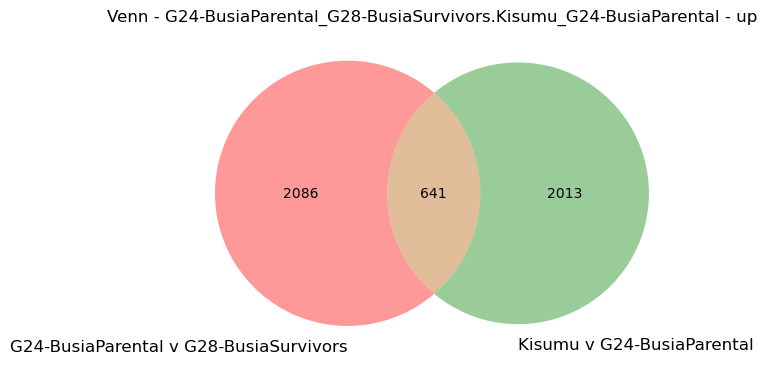

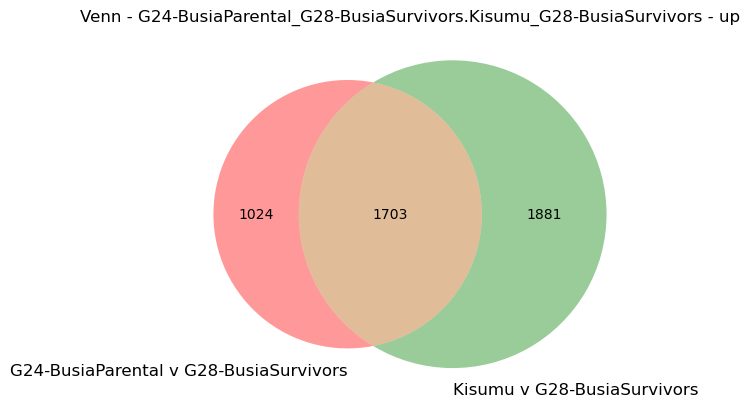

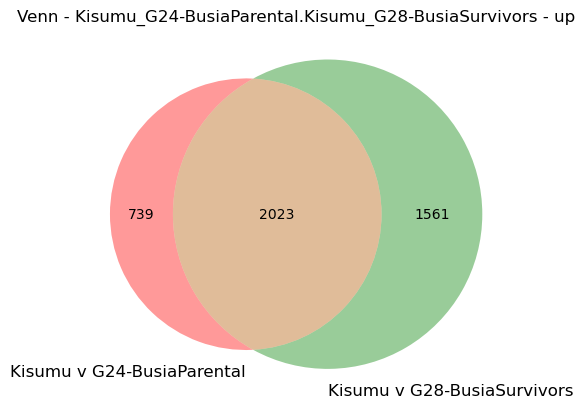

In [24]:
assert len(comparisons) > 1, "Only one differential expression comparison is specified, cannot run venn analysis. Please disable venn in config.yaml or specify more comparisons"

direction = "up"

n_comps = len(comparisons)
for comp1, comp2 in itertools.combinations(comparisons, 2):

    symbol_dict = {'up': ">", 'down': "<"}
    
    comp1sus, comp1res = comp1.split("_")
    comp2sus, comp2res = comp2.split("_")

    de_data1 = pd.read_csv(f"../../results/genediff/{comp1}.csv")
    de_data2 = pd.read_csv(f"../../results/genediff/{comp2}.csv")

    de_data1 = de_data1.query(f"padj < {pval}")
    de_data2 =  de_data2.query(f"padj < {pval}")
    if comp1sus != comp2sus and comp1res != comp2res:
        print("Changing values polarity")
        de_data2['log2FoldChange'] *= -1
    
    de_genes1 = de_data1.query(f"log2FoldChange {symbol_dict[direction]} 0")['GeneID'].to_numpy()
    de_genes2 = de_data2.query(f"log2FoldChange {symbol_dict[direction]} 0")['GeneID'].to_numpy()    
    
    all_de_comps = [comp1, comp2]
    all_de_comps_string = '.'.join(all_de_comps)
    all_de_comps = [a.replace("_", " v ") for a in all_de_comps]

    de1 = set(de_genes1)
    de2 = set(de_genes2)

    s = [de1, de2]
    venn2(s, all_de_comps)
    plt.title(f"Venn - {all_de_comps_string} - {direction}")
    plt.show()
    #plt.savefig(f"results/genediff/venn/{all_de_comps_string}-{direction}-Venn.png")
    plt.close()

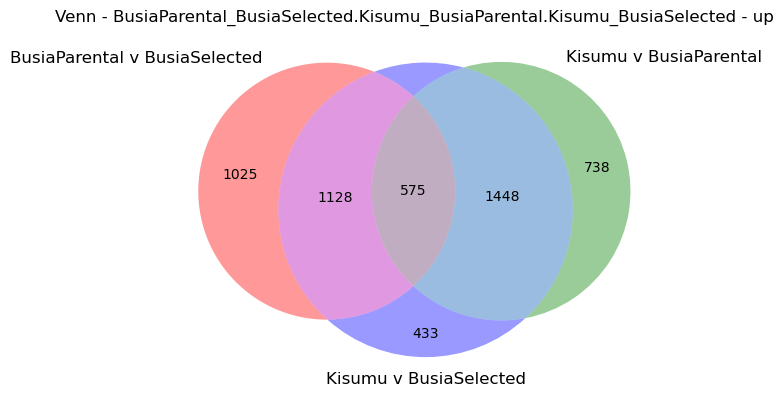

In [13]:
if n_comps >= 3:
    for all_de_comps in itertools.combinations(comparisons, 3):
        comp1, comp2, comp3 = all_de_comps
        all_de_comps_string = '.'.join(all_de_comps)
        all_de_comps = [a.replace("_", " v ") for a in all_de_comps]

        de_genes2 = dict((k, de_genes[k]) for k in (comp1, comp2, comp3))

        s = [set(v) for v in de_genes2.values()]
        
        venn3(s, all_de_comps)
        plt.title(f"Venn - {all_de_comps_string} - {direction}")
        plt.show()
        plt.savefig(f"../../results/genediff/venn/{all_de_comps_string}-{direction}-Venn.png")
        plt.close()